# CNN and MLP - Hybrid Model 

In [1]:
import pandas as pd
from pandas import read_csv, DataFrame
from numpy.random import seed
from sklearn.preprocessing import scale
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout, average
from tensorflow.keras.layers import Conv1D, MaxPooling1D,SpatialDropout1D,GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import boston_housing

In [3]:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()
X_train.shape, y_train.shape

((404, 13), (404,))

In [4]:
X_test.shape, y_test.shape

((102, 13), (102,))

In [5]:
y_test

array([ 7.2, 18.8, 19. , 27. , 22.2, 24.5, 31.2, 22.9, 20.5, 23.2, 18.6,
       14.5, 17.8, 50. , 20.8, 24.3, 24.2, 19.8, 19.1, 22.7, 12. , 10.2,
       20. , 18.5, 20.9, 23. , 27.5, 30.1,  9.5, 22. , 21.2, 14.1, 33.1,
       23.4, 20.1,  7.4, 15.4, 23.8, 20.1, 24.5, 33. , 28.4, 14.1, 46.7,
       32.5, 29.6, 28.4, 19.8, 20.2, 25. , 35.4, 20.3,  9.7, 14.5, 34.9,
       26.6,  7.2, 50. , 32.4, 21.6, 29.8, 13.1, 27.5, 21.2, 23.1, 21.9,
       13. , 23.2,  8.1,  5.6, 21.7, 29.6, 19.6,  7. , 26.4, 18.9, 20.9,
       28.1, 35.4, 10.2, 24.3, 43.1, 17.6, 15.4, 16.2, 27.1, 21.4, 21.5,
       22.4, 25. , 16.6, 18.6, 22. , 42.8, 35.1, 21.5, 36. , 21.9, 24.1,
       50. , 26.7, 25. ])

In [6]:
# normalize features that use different scales and ranges
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [7]:
#plot loss curve
def plot_loss(history):
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)

In [8]:
#train model
def fit_predict_score(model):
    model.compile(optimizer = RMSprop(0.001), loss = 'mse',  metrics = ['mae'])
    history = model.fit(X_train, y_train, batch_size=1, epochs=20, verbose=0, validation_data=(X_test, y_test))
    plot_loss(history)
    score = model.evaluate(X_test, y_test,verbose=1)
    print('Test loss:', score)
    [loss, mae] = model.evaluate(X_test, y_test, verbose=0)
    print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))

### MLP

In [9]:
D = 0.2
S = 1

# Input Data
inputs = Input(shape = (X_train.shape[1],))

#Define MLP 
mlp_net = Dense(64, activation = 'sigmoid')(inputs)
mlp_net = Dropout(rate = D, seed = S)(mlp_net)
mlp_net = Dense(64, activation = 'sigmoid')(mlp_net)
mlp_net = Dropout(rate = D, seed = S)(mlp_net)
mlp_out = Dense(1, activation = 'linear')(mlp_net)
mlp_mdl = Model(inputs = inputs, outputs = mlp_out)

In [10]:
mlp_mdl.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense (Dense)               (None, 64)                896       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,121
Trainable params: 5,121
Non-trainable par

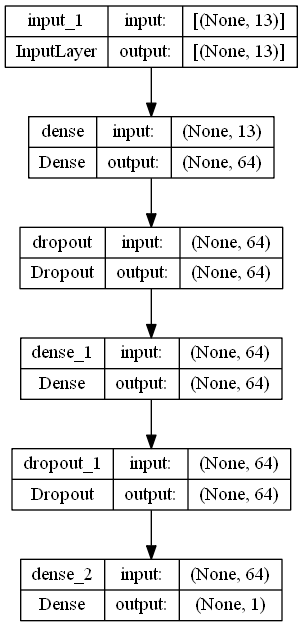

In [11]:
plot_model(mlp_mdl, show_shapes = True, show_layer_names = True)

In [12]:
#train model
#fit_predict_score(mlp_mdl)

In [13]:
(X_train.shape[1], 1)

(13, 1)

## CNN

#### Spatial Dropout 

https://keras.io/api/layers/regularization_layers/spatial_dropout1d/

Same function as Dropout, however, it drops entire 1D feature maps instead of individual elements. If adjacent frames within feature maps are strongly correlated (as is normally the case in early convolution layers) then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. 

In [14]:
#Define CNN 
cnv_net = Reshape((X_train.shape[1], 1))(inputs)
cnv_net = Conv1D(32, 1, activation = 'relu', padding = "valid", strides=1)(cnv_net)
cnv_net = SpatialDropout1D(0.1)(cnv_net)
cnv_net = Conv1D(64, 3, activation = 'relu', padding = "valid", strides=1)(cnv_net)
cnv_net = SpatialDropout1D(0.1)(cnv_net)
cnv_net = Conv1D(64, 5, activation = 'relu', padding = "valid",strides=1)(cnv_net)
cnv_net = GlobalMaxPooling1D()(cnv_net)
cnv_net = Dense(32, activation="relu")(cnv_net)
cnv_net = Dropout(0.2)(cnv_net)
cnv_net = Flatten()(cnv_net)
cnv_out = Dense(1, activation = 'linear')(cnv_net)
cnv_mdl = Model(inputs = inputs, outputs = cnv_out)

In [15]:
cnv_mdl.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 reshape (Reshape)           (None, 13, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 13, 32)            64        
                                                                 
 spatial_dropout1d (SpatialD  (None, 13, 32)           0         
 ropout1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            6208      
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 11, 64)           0         
 lDropout1D)                                               

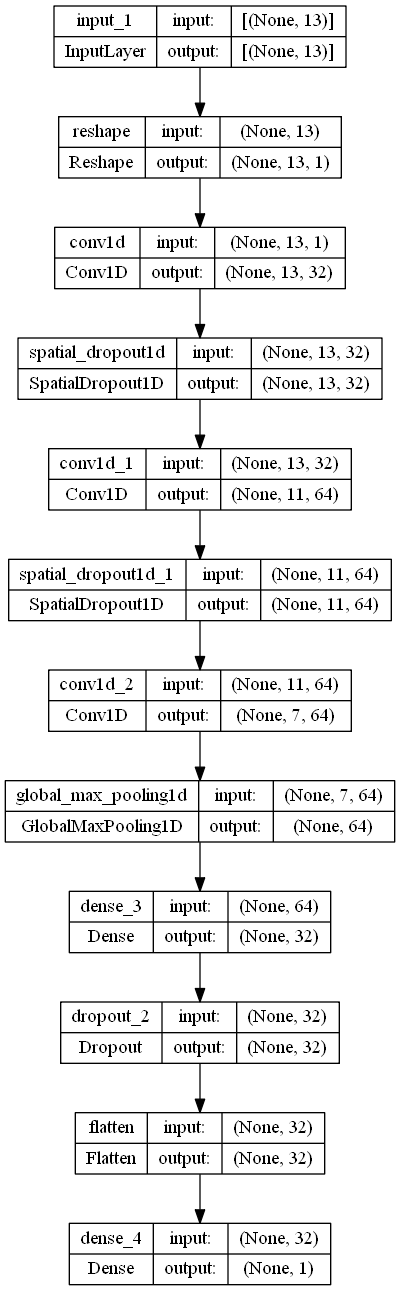

In [16]:
plot_model(cnv_mdl, show_shapes = True, show_layer_names = True)

In [17]:
#train model
#fit_predict_score(cnv_mdl)

## Combined Model

In [18]:
# Combine NLP and CNN
con_out = average([mlp_out, cnv_out])
con_mdl = Model(inputs = inputs, outputs = con_out)
con_mdl.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 13, 1)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 13, 32)       64          ['reshape[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 13, 32)      0           ['conv1d[0][0]']                 
 out1D)                                                                                     

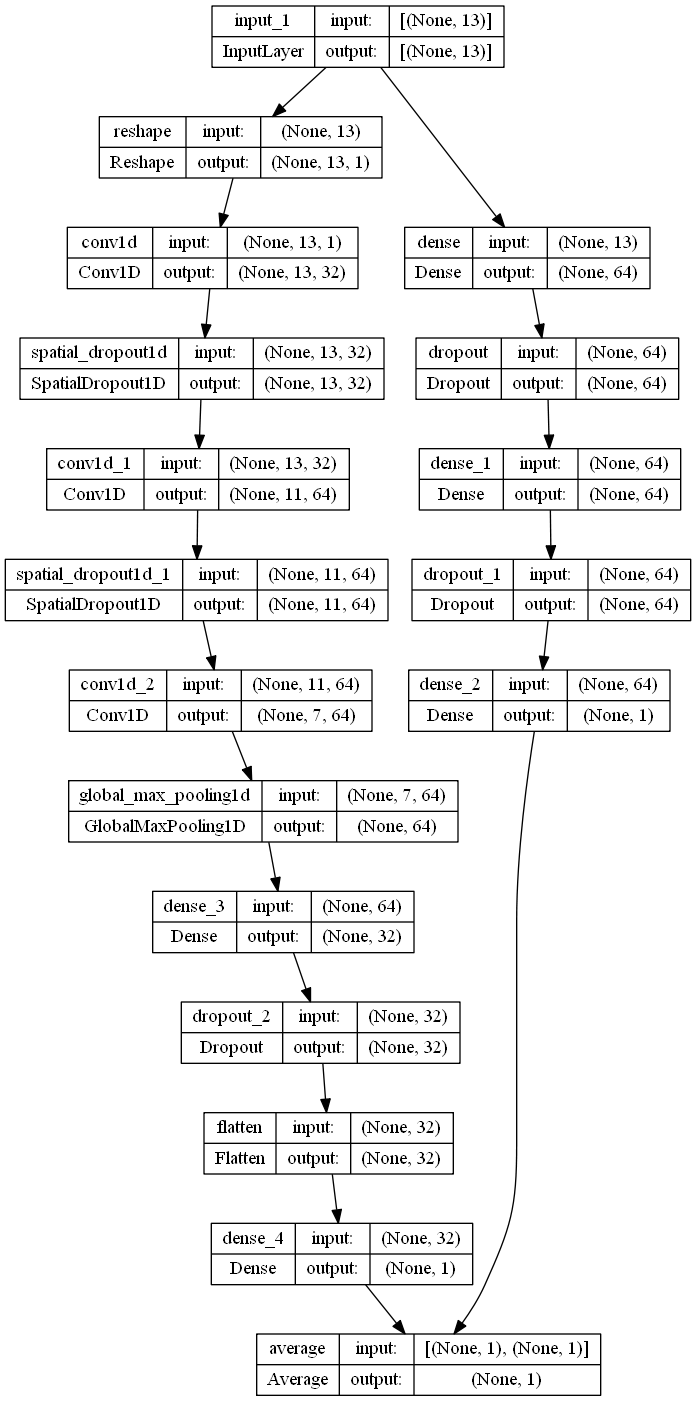

In [19]:
plot_model(con_mdl, show_shapes = True, show_layer_names = True)

4/4 [==============================] - 0s 14ms/step - loss: 26.4729 - mae: 3.6105
Test loss: [26.472862243652344, 3.610482931137085]
Testing set Mean Abs Error: $3610.48


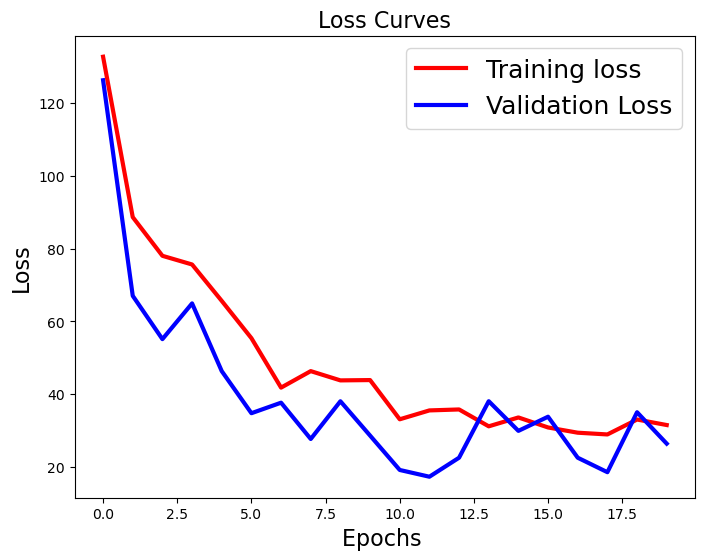

In [20]:
#train model
fit_predict_score(cnv_mdl)